# 线性回归梯度下降 gradient decent
$y = \theta _0 + \theta _1  x$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 生成一个测试序列
np.random.seed(42)
n_points = 100
x = np.linspace(1, n_points, n_points)
noise = np.random.normal(0, 9, n_points)
y = 3.2  + 0.8 * x +  noise
print('x:', x)
print('y:', y)


x: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100.]
y: [ 8.47042738  3.55562129 11.42919684 20.10726871  5.09261963  5.89276739
 23.01291534 16.50691256  6.17473053 16.08304039  7.82924076  8.60843222
 15.77766044 -2.8195222  -0.32426049 10.93941224  7.68451992 20.42822599
 10.22778332  6.48926669 33.19083892 18.7680133  22.20775384  9.57726632
 18.30055548 24.99830331 14.4410578  28.98128217 20.99425179 24.57475625
 22.58464049 45.47050366 29.47852498 20.88060164 38.60290421 21.01240715
 34.67977236 15.96296889 22.44632556 36.9717511

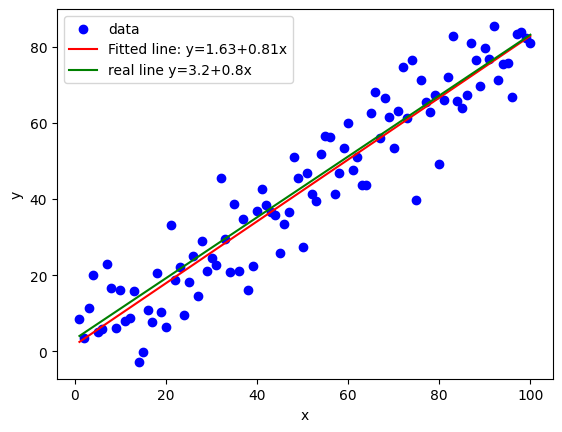

In [3]:

coeffs = np.polyfit(x, y, 1)  # 返回 [slope, intercept] 现用最小二乘法拟合一个参数
fit_line = np.poly1d(coeffs)

plt.scatter(x, y, label="data", color='blue')
plt.plot(x, fit_line(x), label=f"Fitted line: y={coeffs[1]:.2f}+{coeffs[0]:.2f}x", color='red')
plt.plot(x,  3.2  + 0.8 * x, label="real line y=3.2+0.8x", color='green')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

$\hat{y} = \theta _0 + \theta _1  x_i$

cost function:

$h = \frac{1}{2 m} Σ(\hat{y} - y)^2$

m is sample size


In [4]:
def cost_function(y, x, theta0, theta1):
    c = sum((theta0 + theta1 * x - y) ** 2) / (2 *len(y))
    return c

In [5]:
from tqdm import tqdm
from itertools import product
costs = []
theta0_list = np.linspace(-20, 20, 50)
theta1_list = np.linspace(-2, 4, 50)
t0 = []
t1 = []
for i, (theta0, theta1) in tqdm(enumerate(product(theta0_list,theta1_list))):
    # print(theta0, theta1)
    c = cost_function(y, x, theta0, theta1)
    costs.append(c)
    t0.append(theta0)
    t1.append(theta1)

2500it [00:00, 100034.92it/s]


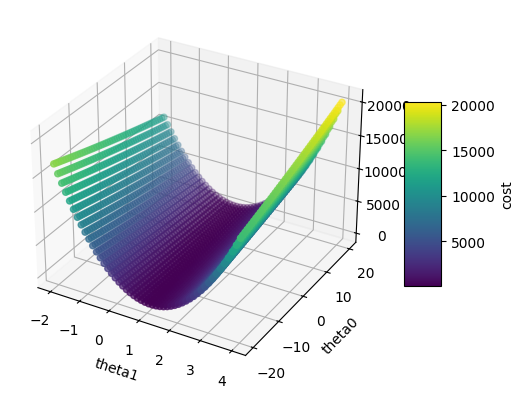

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(t1, t0, costs, c=costs, cmap='viridis')

ax.set_xlabel("theta1")
ax.set_ylabel("theta0")
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label="cost")

plt.show()

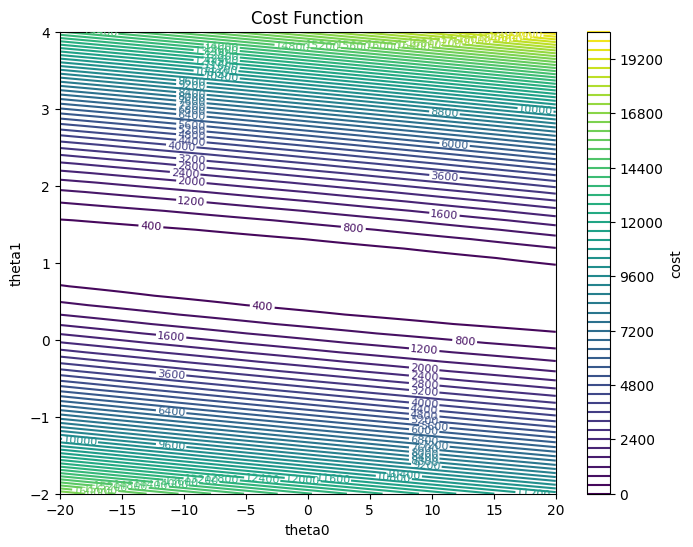

In [7]:
costs = np.array(costs)

# 参数数量
num_theta0 = len(theta0_list)  # 50
num_theta1 = len(theta1_list)  # 50

# reshape 得到矩阵 C，此时矩阵的行数对应 theta0，列对应 theta1
C = costs.reshape(num_theta0, num_theta1)
# 由于 meshgrid(theta0_list, theta1_list) 得到坐标形状为 (num_theta1, num_theta0)，
# 为了正确匹配，进行转置
C_plot = C.T

# 生成网格坐标
T0, T1 = np.meshgrid(theta0_list, theta1_list)

# 绘制轮廓线图（不填充，即显示一圈一圈的线）
plt.figure(figsize=(8, 6))
contours = plt.contour(T0, T1, C_plot, levels=50, cmap="viridis")
plt.clabel(contours, inline=True, fontsize=8)  # 显示轮廓线上的数值，也可以不加此行
plt.xlabel("theta0")
plt.ylabel("theta1")
plt.title("Cost Function")
plt.colorbar(contours, label="cost")
plt.show()


可以观察到有能使cost最小的参数解，使用梯度下降求解参数（链式法则求导）

$\theta _0: \theta _0 - \alpha \Sigma \frac{1}{m}(\hat{y}- y)$

$\theta _1: \theta _1 - \alpha \Sigma \frac{1}{m}(\hat{y}- y)x$

先定义中间变量  $p = \Sigma \frac{1}{m}(\hat{y}- y)$

In [8]:
def process(y, x, theta0, theta1, type=0): 
    if type == 0:
        p = sum(theta0 + theta1 * x - y) / len(y)
    elif type == 1:
        p = sum((theta0 + theta1 * x - y) * x) / len(y)
    else:
        raise ValueError('plz correct type')
    return p 

In [12]:
# init
theta0 = 0
theta1 = 0
alpha0 = 0.5
alpha1 = 1e-4
max_iter_num = 1000
tol = 1e-6    # 收敛容忍度
cost = cost_function(y, x, theta0, theta1)
num = 0


iter_list = []
theta0_list = []
theta1_list = []
cost_list = []
cost_diff_list = []

# 保存初始值
iter_list.append(0)
theta0_list.append(theta0)
theta1_list.append(theta1)
cost_list.append(cost)
cost_diff_list.append(0)  # 初始时 cost 差值为0

for i in range(max_iter_num):
    grad0 = process(y, x, theta0, theta1, 0)
    grad1 = process(y, x, theta0, theta1, 1)
    new_theta0 = theta0 - alpha0 * grad0
    new_theta1 = theta1 - alpha1 * grad1
    theta0, theta1 = new_theta0, new_theta1
    # print(theta0, theta1)
    c = cost_function(y, x, theta0, theta1)
    cost_diff_list.append(cost - c)
    iter_list.append(i)
    theta0_list.append(theta0)
    theta1_list.append(theta1)
    cost_list.append(c)
    if abs(cost - c) < tol:
        break
    cost = c
    num += 1

print("\n最终参数:", theta0, theta1)
print("\n最终迭代次数:", num)




最终参数: 1.6398419127601984 0.8124030915725702

最终迭代次数: 149


In [10]:
print('\n最小二乘法参数',coeffs[1], coeffs[0])
print('\n梯度下降参数',theta0, theta1)


最小二乘法参数 1.6321449793611944 0.812539333942415

梯度下降参数 1.6398419127601984 0.8124030915725702


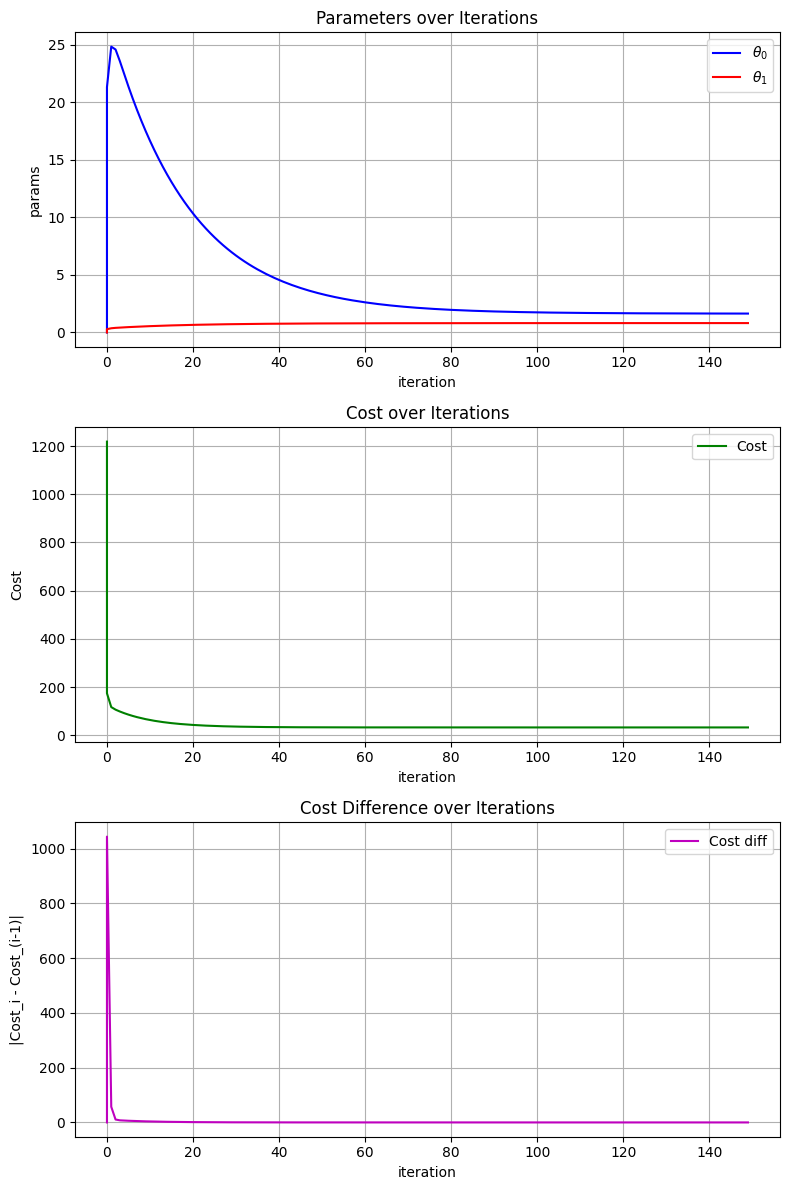

In [ ]:
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 12)) 

# 1. 参数 theta0 与 theta1 随迭代次数的变化
plt.subplot(3, 1, 1)
plt.plot(iter_list, theta0_list, label=r'$\theta_0$', color='b')
plt.plot(iter_list, theta1_list, label=r'$\theta_1$', color='r')
plt.xlabel("iteration")
plt.ylabel("params")
plt.title("Parameters over Iterations")
plt.legend()
plt.grid(True)

# 2. Cost 随迭代次数的变化
plt.subplot(3, 1, 2)
plt.plot(iter_list, cost_list, label="Cost", color='g')
plt.xlabel("iteration")
plt.ylabel("Cost")
plt.title("Cost over Iterations")
plt.legend()
plt.grid(True)

# 3. Cost 差值（收敛情况）随迭代次数的变化
plt.subplot(3, 1, 3)
plt.plot(iter_list, cost_diff_list, label="Cost diff", color='m')
plt.xlabel("iteration")
plt.ylabel("|Cost_i - Cost_(i-1)|")
plt.title("Cost Difference over Iterations")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
